# Loading and working with processed paedal Visium data - post cell2location deconvolution

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import re
import os
import scipy.stats
from numpy import asarray as ar
from collections import Counter
import anndata as ad
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())
sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2

Running Scanpy 1.9.1, on 2023-09-08 15:02.


In [2]:
## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

In [3]:
# output folder 
import os
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
os.getcwd()

'/nfs/team205/ny1/ThymusSpatialAtlas/Figure4'

# Explore gene expression and cytokine profiles  

AnnData object with n_obs × n_vars = 22553 × 28164
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Sequen

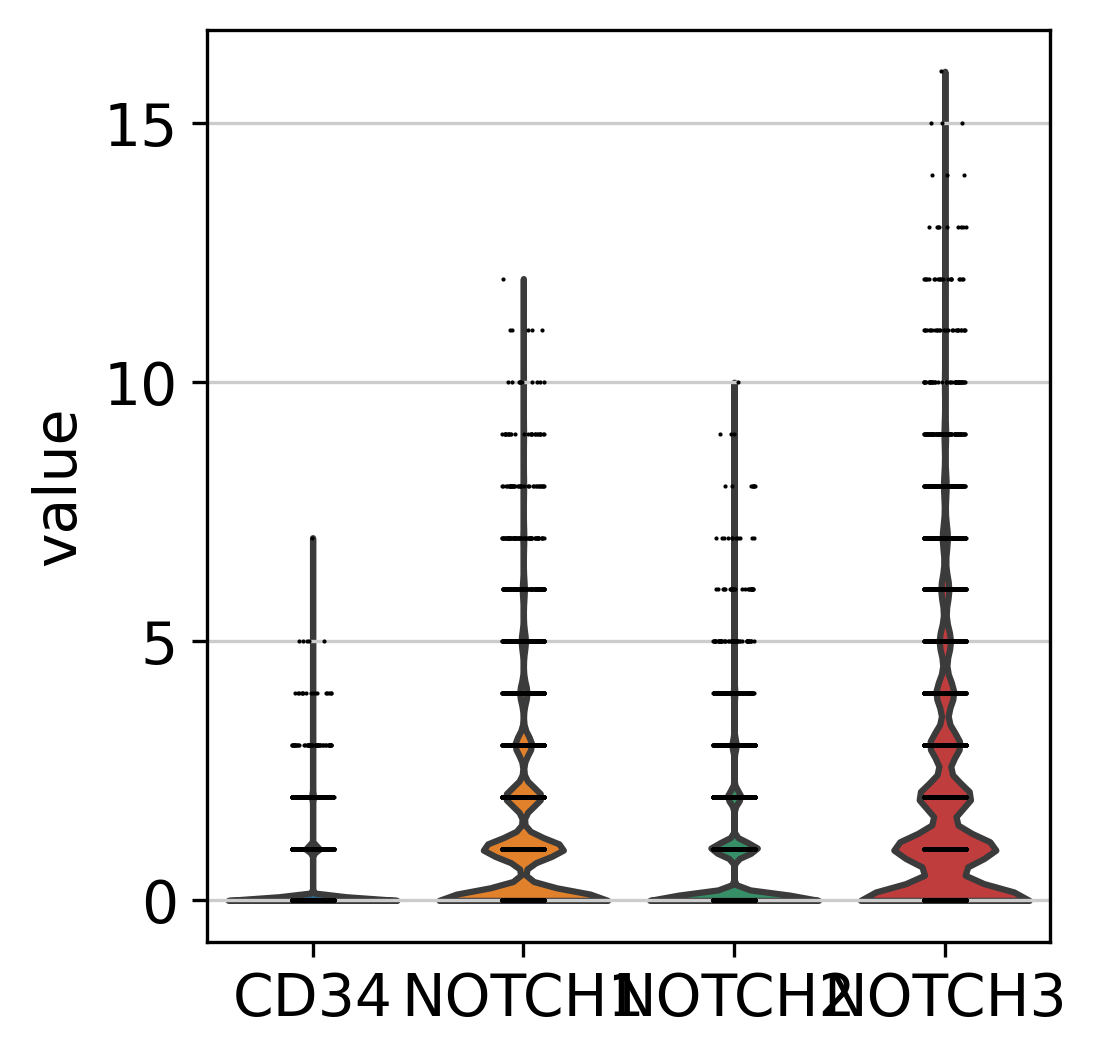

In [4]:
adata_paed_cma =  sc.read_h5ad('/nfs/team205/ny1/ThymusSpatialAtlas/Figure2/adata_paed_cma_v11.h5ad')
adata_paed_cma
# make sure it's count data 
list = ['CD34','NOTCH1','NOTCH2','NOTCH3',]
sc.pl.violin(adata_paed_cma, keys =list,layer='counts')

In [5]:
# remove artifacts structures 
import warnings
warnings.filterwarnings('ignore')
adata_paed_cma = adata_paed_cma[adata_paed_cma.obs['annotations_level_1']!="fat"].copy()
adata_paed_cma = adata_paed_cma[adata_paed_cma.obs['annotations_level_1']!="vessels"].copy()

# bin axis 

Capsular= (-0.75>cma_v2)
Sub-Capsular= (-0.75<=cma_v2) & (-0.62>cma_v2)
Cortical level I= (-0.62<=cma_v2) & (-0.55>cma_v2)
Cortical level II= (-0.55<=cma_v2) & (-0.45>cma_v2)
Cortical level III= (-0.45<=cma_v2) & (-0.3>cma_v2)
Cortical CMJ= (-0.3<=cma_v2) & (0.1>cma_v2)
Medullar CMJ= (0.1<=cma_v2) & (0.55>cma_v2)
Medullar level I= (0.55<=cma_v2) & (0.65>cma_v2)
Medullar level II= (0.65<=cma_v2) & (0.7>cma_v2)
Medullar level III= (0.7=<cma_v2)


Cortical level II     4110
Cortical level I      3652
Cortical level III    2564
Capsular              2151
Medullar level III    2033
Cortical CMJ          1915
Medullar CMJ          1880
Sub-Capsular          1520
Medullar level I      1488
Medullar level II     1221
Name: manual_bin_cma_v2, dtype: int64

<AxesSubplot:>

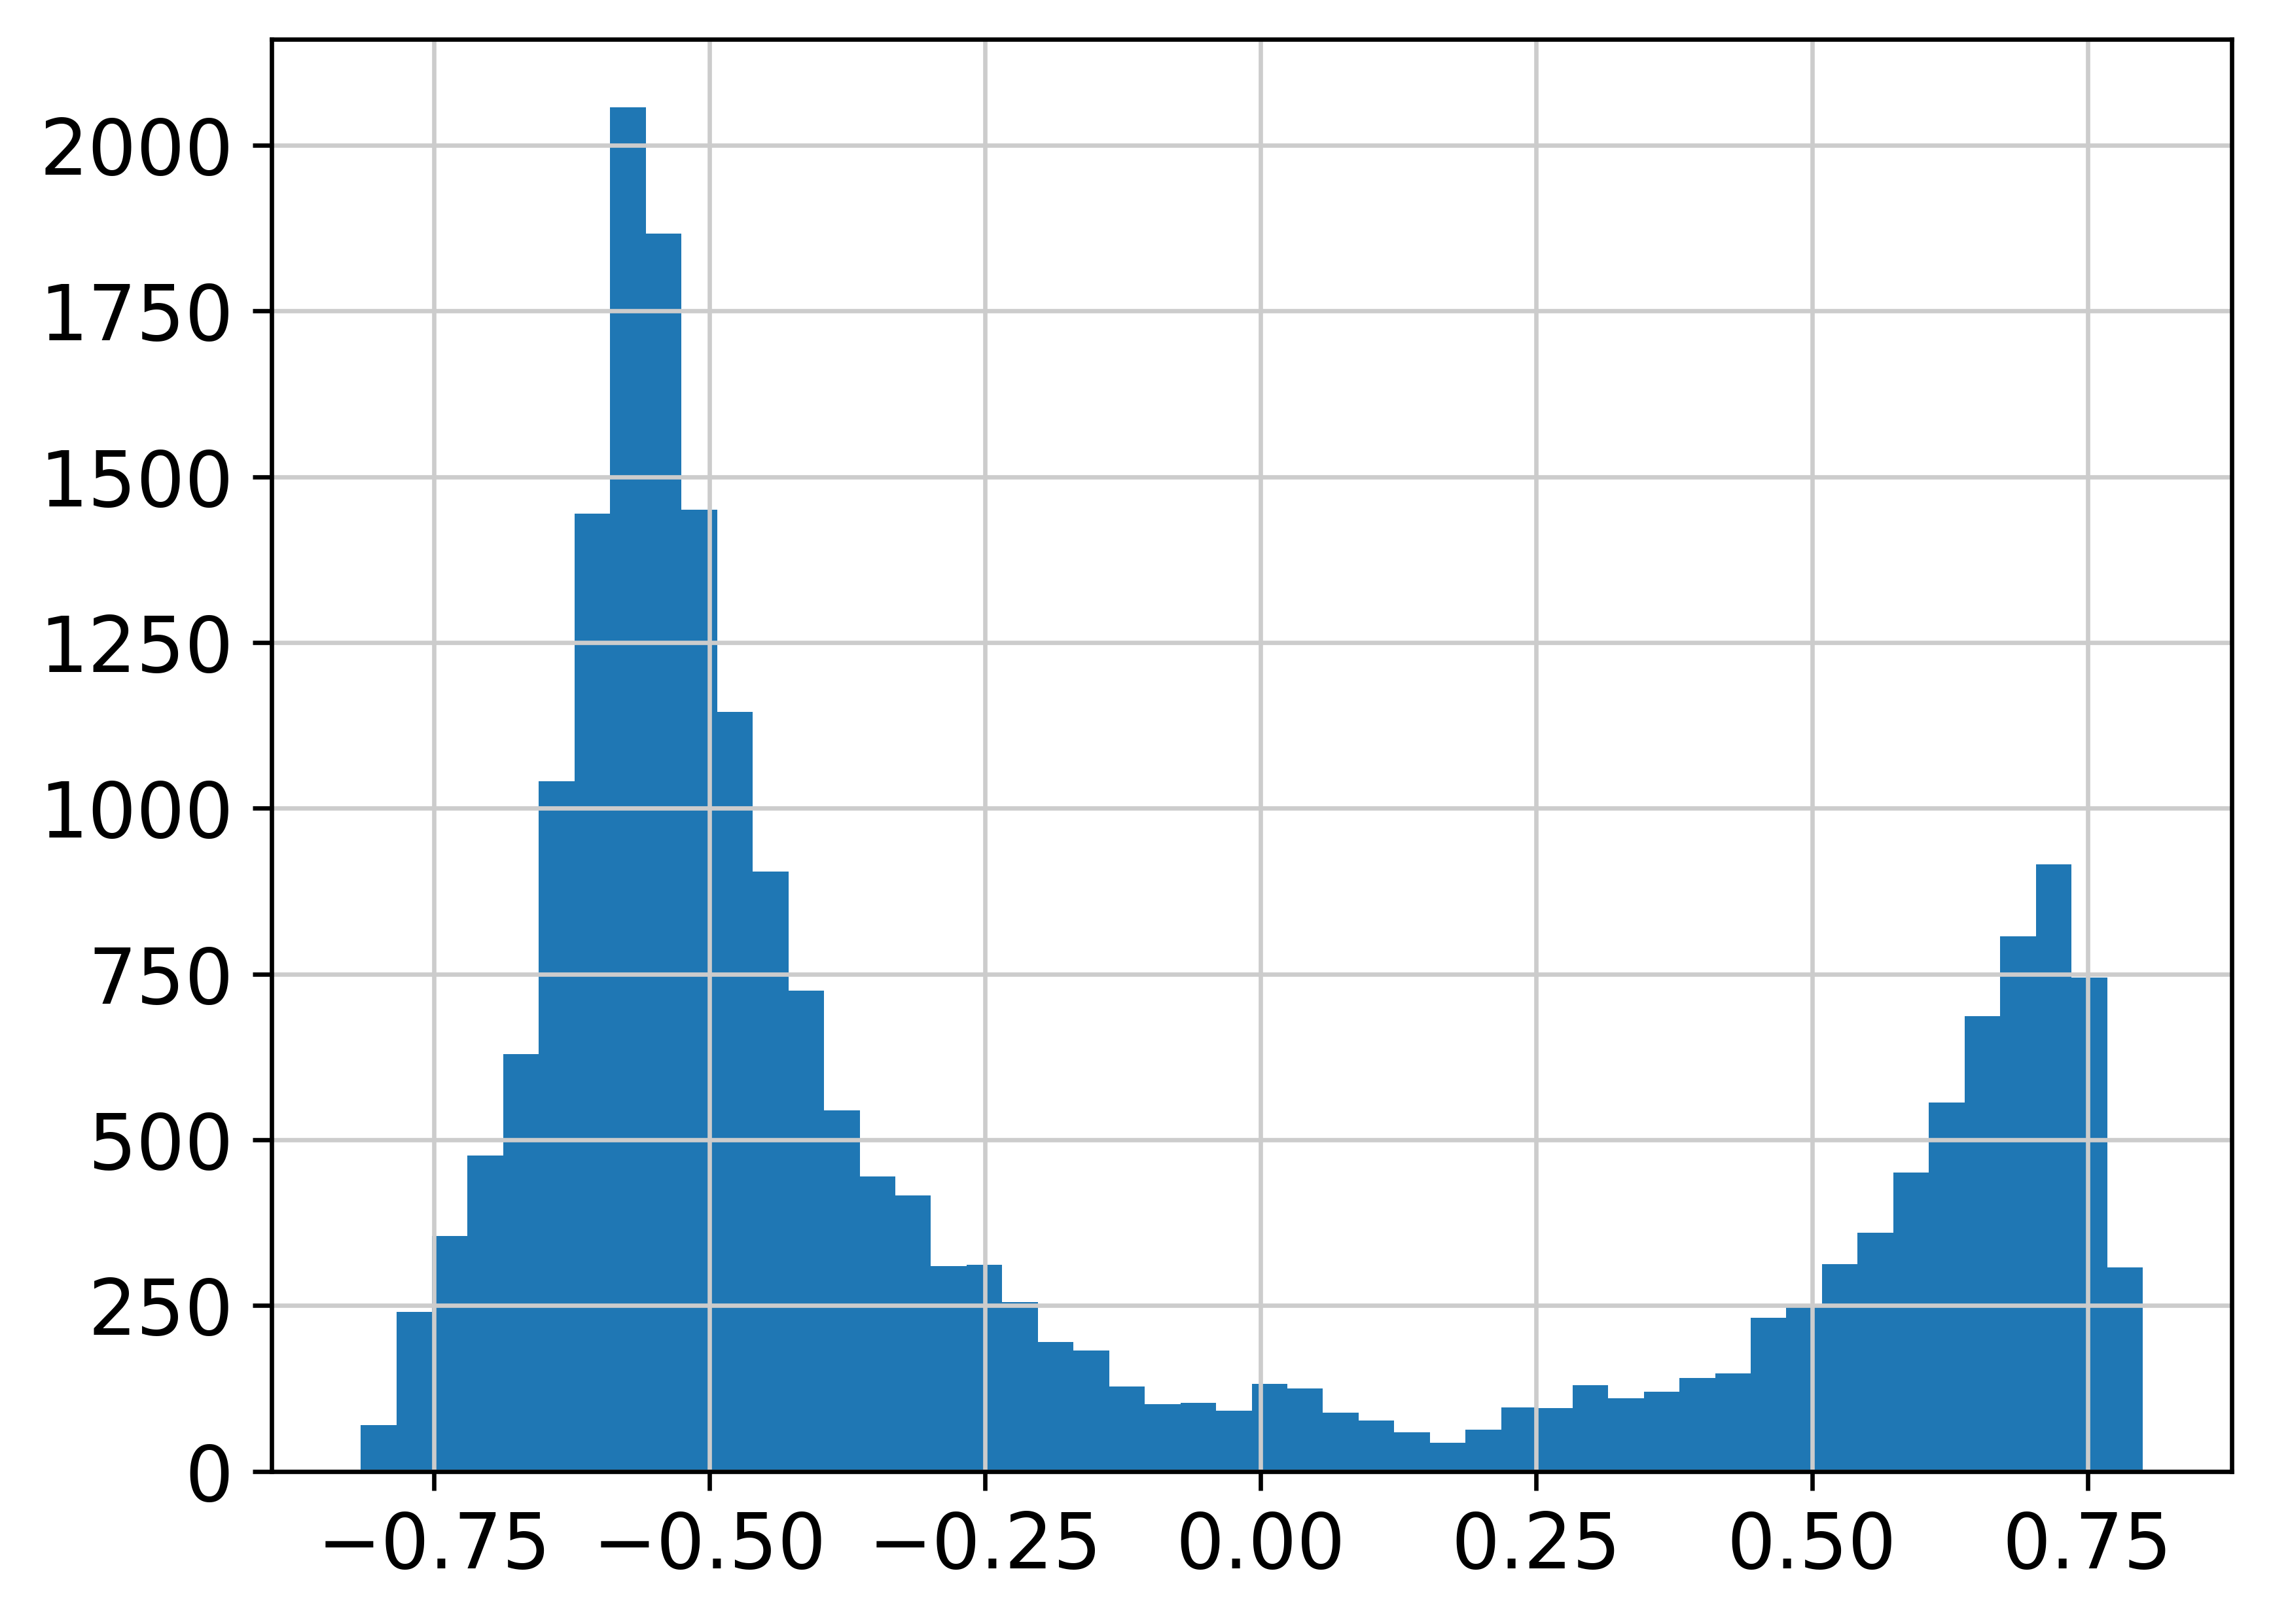

In [7]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/software/ImageSpot/')
import imagespot as ims
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level I','Cortical level II','Cortical level III','Cortical CMJ','Medullar CMJ','Medullar level I','Medullar level II','Medullar level III']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
adata_paed_cma.obs = ims.bin_axis(ct_order ,ct2_values,adata_paed_cma.obs,'cma_v2')   
adata_paed_cma.obs.loc[adata_paed_cma.obs['annotations_level_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'
adata_paed_cma.obs['manual_bin_cma_v2'] = adata_paed_cma.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
adata_paed_cma.obs['manual_bin_cma_v2'].value_counts()
adata_paed_cma.obs['cma_v2'].hist(bins=50)
plt.show()

# Analyse cell level

In [8]:
celltypes = adata_paed_cma.uns['mod']['factor_names']
cellab_paed = sc.AnnData(adata_paed_cma.obs[celltypes], 
                         obs = adata_paed_cma.obs.drop(celltypes, axis = 1),obsm = adata_paed_cma.obsm)

cellab_paed.var_names
sc.pp.normalize_total(cellab_paed,target_sum=100)
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')


Index(['B-memory', 'B-naive', 'B-plasma', 'DC1', 'DC2', 'EC-Art', 'EC-Art-ELN',
       'EC-Cap', 'EC-Lymphatic', 'EC-Ven', 'InterloFb', 'Macrophage-APOC2',
       'Macrophage-SPIC1', 'Monocyte_IL1B', 'Myelocyte', 'Neutrophil',
       'Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'PeriloFb', 'SMC',
       'TEC-cilliated', 'TEC-myo', 'TEC-neuro', 'T_CD4', 'T_CD8',
       'T_CD8_memory', 'T_CD8αα(I)', 'T_CD8αα(II)', 'T_CD8αα(entry)',
       'T_DN(P)', 'T_DN(Q)', 'T_DN(early)', 'T_DP(P)', 'T_DP(Q)',
       'T_DP(Q)-CD99', 'T_DP(Q)-early', 'T_DP(Q)-late_vdj', 'T_ETP', 'T_NK',
       'T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2', 'T_Treg_CD8',
       'T_Treg_mature', 'T_Treg_recirc', 'T_innate_type_3', 'T_αβT(entry)',
       'T_γδT', 'aDC1', 'aDC2', 'aDC3', 'cTECI', 'cTECII', 'cTECIII', 'mTECI',
       'mTECI-trans', 'mTECII', 'mTECIII', 'mcTEC', 'medFB-MHCIIh', 'medFb',
       'medFb-RGS5', 'pDC'],
      dtype='object')

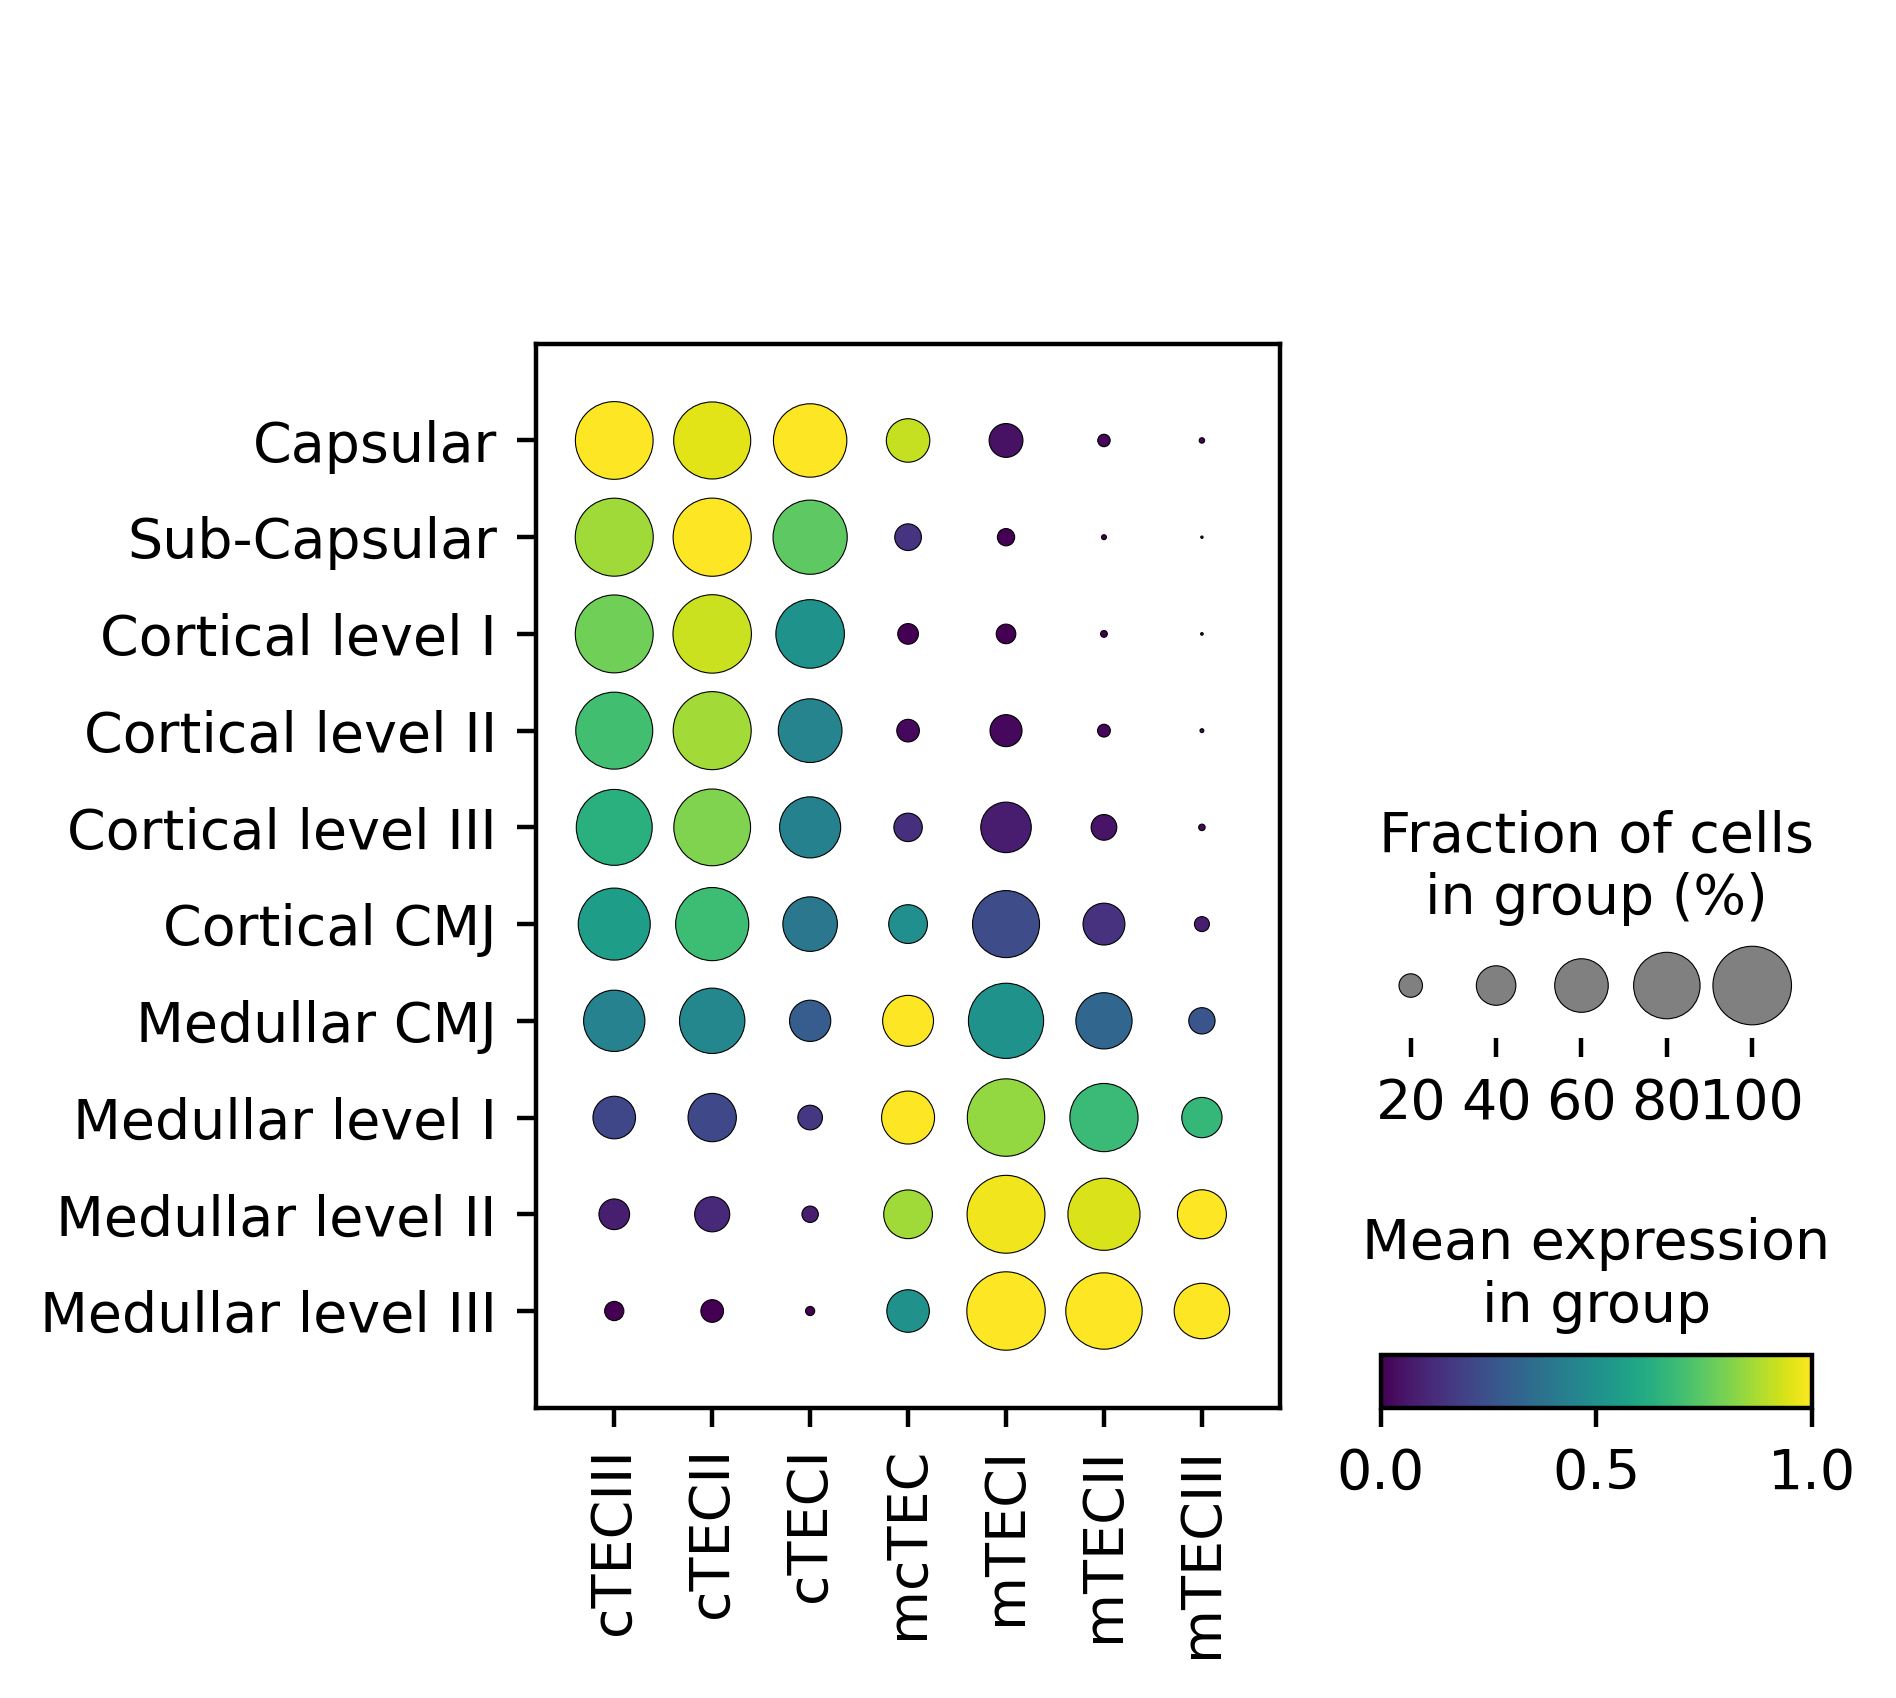

In [9]:
cells = ['cTECIII','cTECII','cTECI','mcTEC','mTECI','mTECII','mTECIII']

cutoff = 0.25
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')

sc.set_figure_params(figsize=[7,7],fontsize=12,dpi=200)
sc.pl.dotplot(cellab_paed,var_names=cells,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_tec_cutoff'+str(cutoff)+'.pdf')
      

Cortical level II     4101
Cortical level I      3649
Cortical level III    2554
Capsular              2078
Medullar level III    1940
Cortical CMJ          1893
Medullar CMJ          1786
Sub-Capsular          1516
Medullar level I      1426
Medullar level II     1150
PVS                    228
HC                     213
Name: annotation_figure_1, dtype: int64

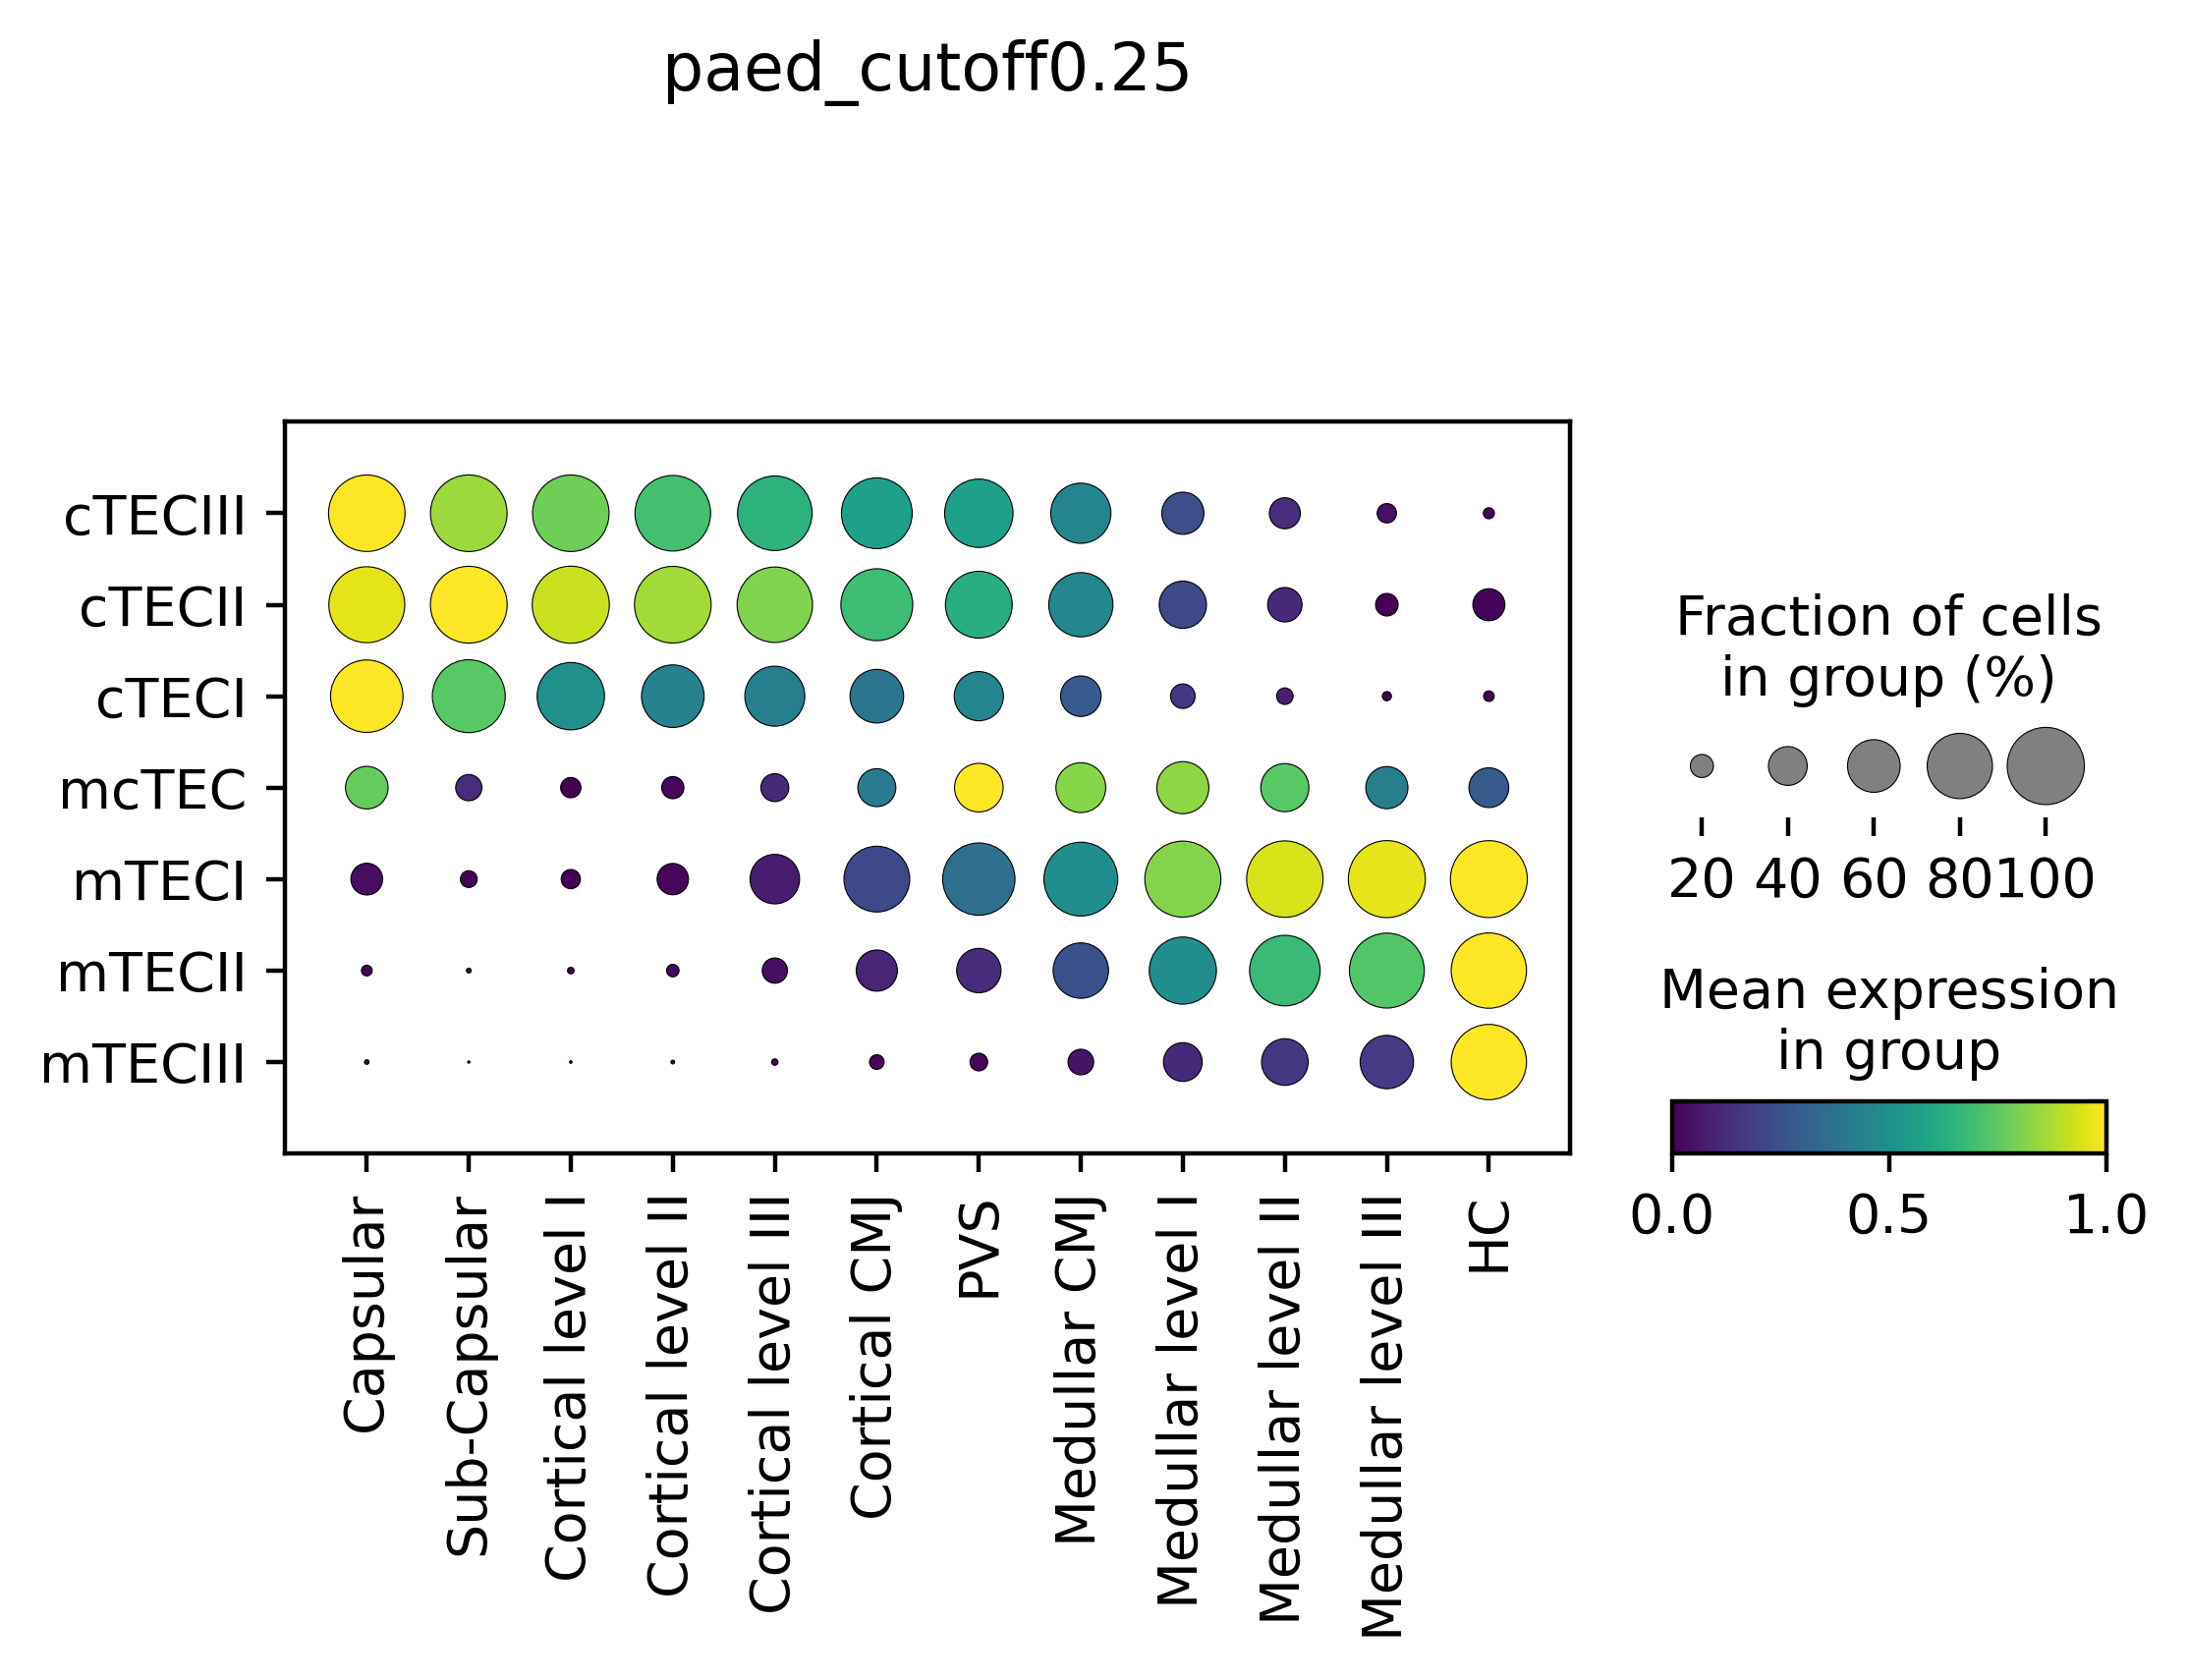

In [24]:
# remove artifacts structures 
import warnings
warnings.filterwarnings('ignore')
cutoff = 0.25

cellab_paed.obs['annotation_figure_1'] = cellab_paed.obs['manual_bin_cma_v2']
cellab_paed.obs['annotation_figure_1'] = cellab_paed.obs['annotation_figure_1'].astype('object')
# cellab_paed.obs.loc[np.array(cellab_paed.obs['annotations_level_0'].isin(['Edge'])) ,'annotation_figure_1'] = "Capsule"
cellab_paed.obs.loc[np.array(cellab_paed.obs['annotations_level_1'].isin(['HS'])) ,'annotation_figure_1'] = "HC"
cellab_paed.obs.loc[np.array(cellab_paed.obs['annotations_level_1'].isin(['PVS'])) ,'annotation_figure_1'] = "PVS"

cellab_paed.obs['annotation_figure_1'] = cellab_paed.obs['annotation_figure_1'].astype('category')
cellab_paed = cellab_paed[cellab_paed.obs['annotation_figure_1']!='Artifacts']
cellab_paed = cellab_paed[cellab_paed.obs['annotation_figure_1']!='Background']
cellab_paed = cellab_paed[cellab_paed.obs['annotation_figure_1']!='Unassigned']

cellab_paed.obs['annotation_figure_1'].value_counts()
ct_order = ['Capsular','Sub-Capsular','Cortical level I','Cortical level II','Cortical level III','Cortical CMJ','PVS','Medullar CMJ','Medullar level I','Medullar level II','Medullar level III','HC']
cellab_paed.obs['annotation_figure_1'] = cellab_paed.obs['annotation_figure_1'].cat.reorder_categories(ct_order)
import seaborn as sns
# sns.set_palette('colorblind')

sc.set_figure_params(figsize=[7,7],fontsize=12,dpi=200)
sc.pl.dotplot(cellab_paed,var_names=cells,
               groupby='annotation_figure_1',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_tec_anno1'+str(cutoff)+'.pdf',title='paed_cutoff'+str(cutoff),swap_axes=True)
           

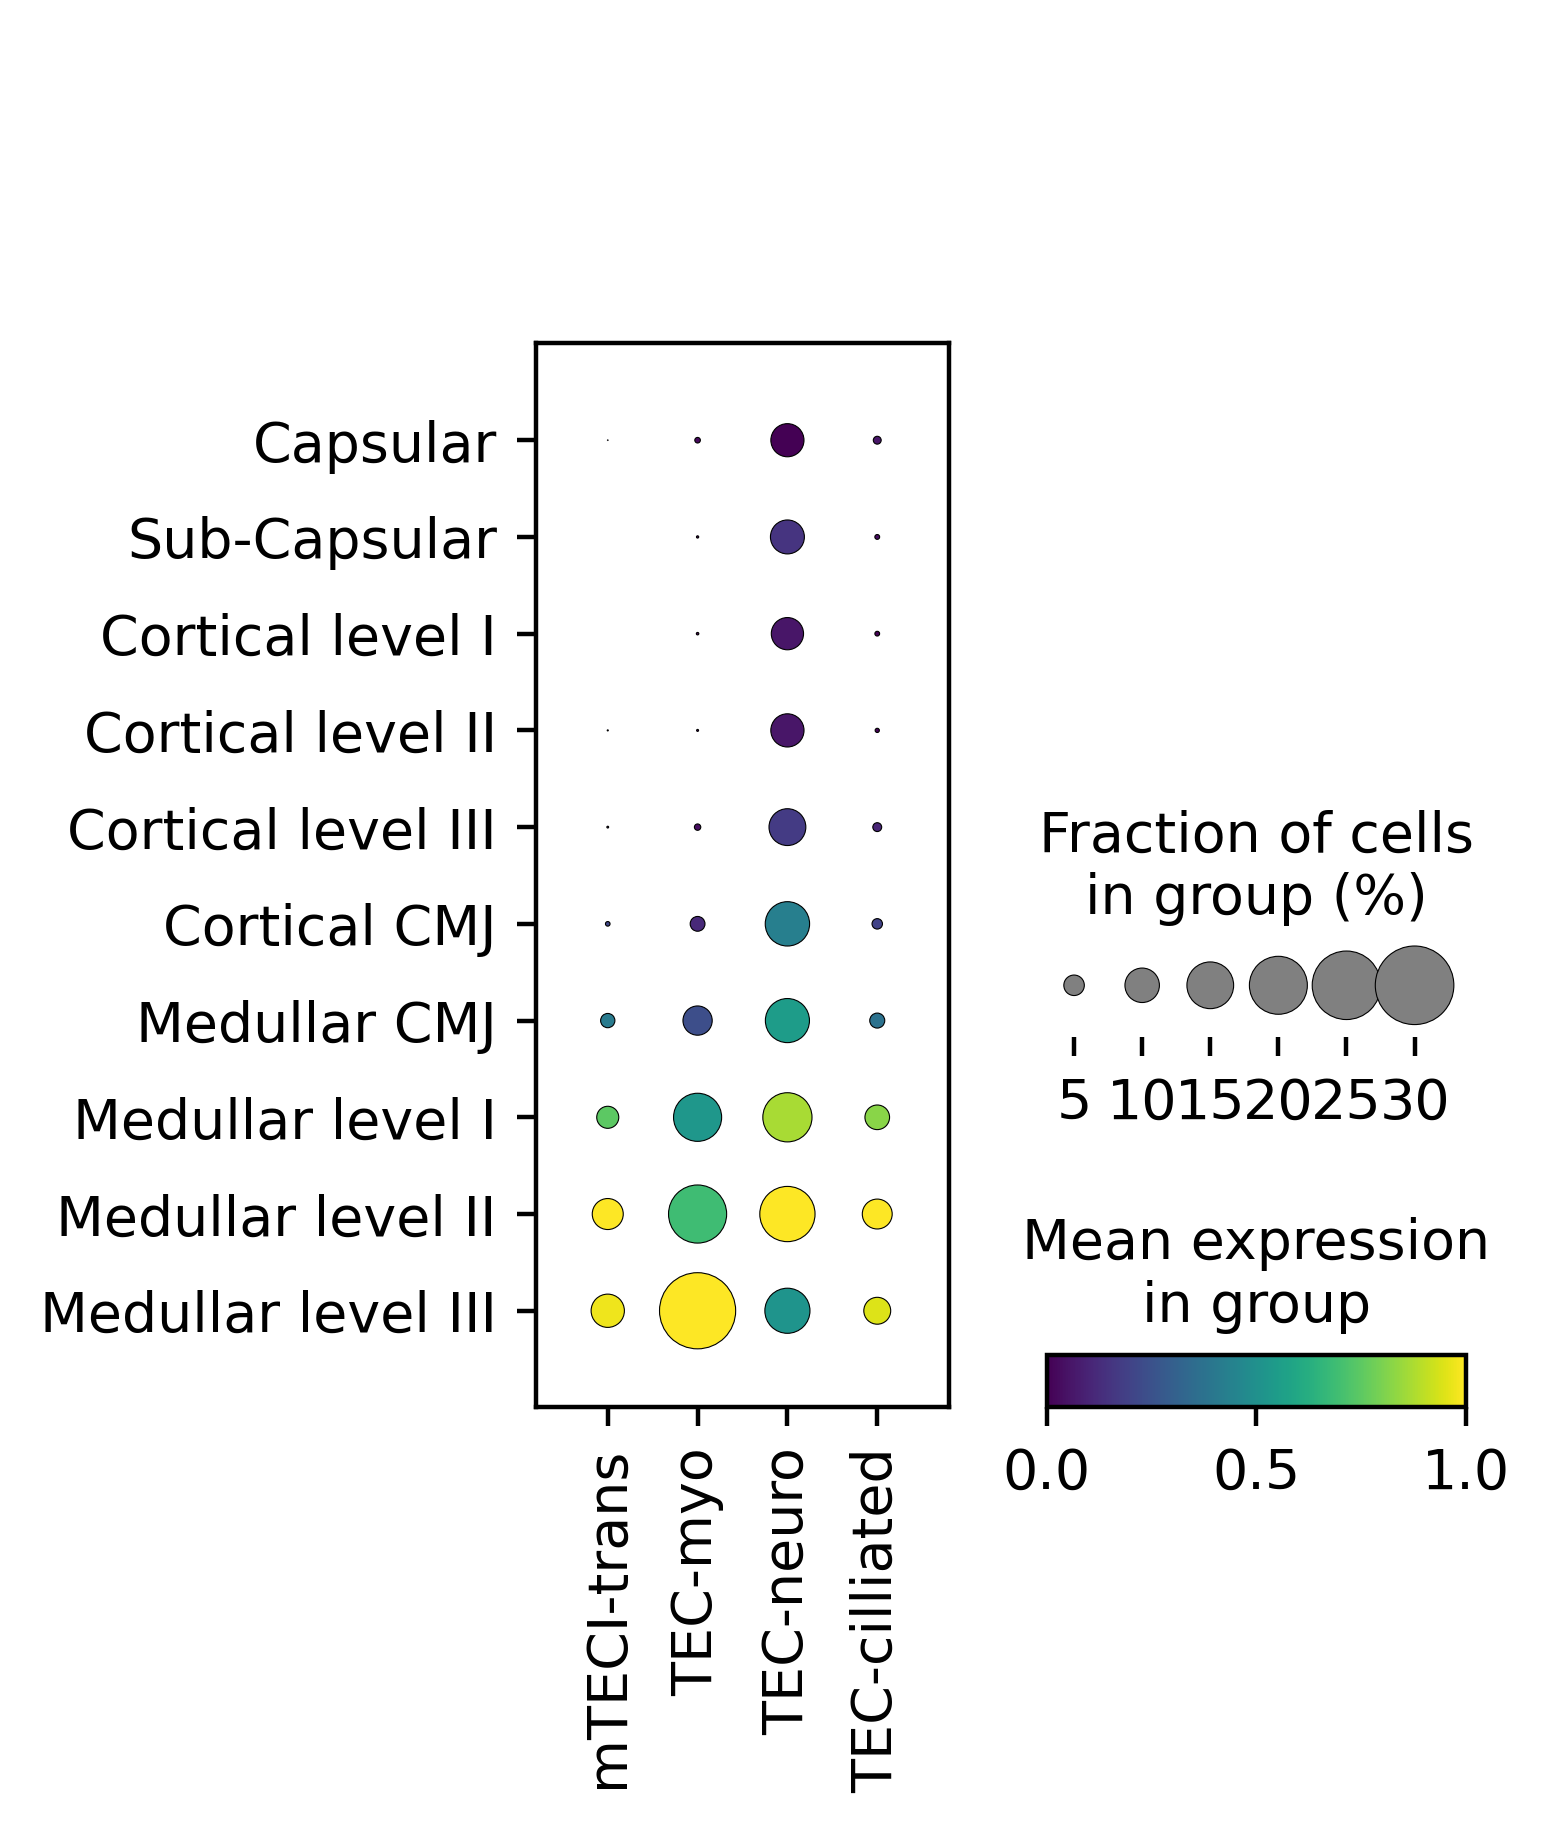

In [11]:
cutoff = 0.25
cells = ['mTECI-trans','TEC-myo', 'TEC-neuro', 'TEC-cilliated']
sc.pl.dotplot(cellab_paed,var_names=cells,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_tec_spacial'+str(cutoff)+'.pdf')
              

# plot rest of cells - paed

In [20]:
sc.set_figure_params(figsize=[5,5],fontsize=10,dpi=100)

dict_anno = {
    'T_special': ['T_CD8αα(entry)','T_CD8αα(I)', 'T_CD8αα(II)',   'T_γδT', 'T_innate_type_1', 'T_innate_type_3','T_cycling', 'T_CD8-Prolif', 'T_CD8_memory','T_NK_dev', 'T_NK', 'T_NK_fetal'],
    'T_DN_DP': ['T_DP(Q)-early','T_DN(Q)-CD99', 'T_DN(Q)-HSPH1', 'T_DP(Q)-CD99', 'T_DP(Q)-HSPH1',  'T_DP(Q)-late_vdj'],
    'T_Treg': ['T_reg(agonist)', 'T_reg(diff)-FOXP3Lo', 'T_reg(diff)-FOXP3hi', 'T_Treg_mature', 'T_Treg_CD8', 'T_Treg_recirc'],
    'B': ['B-naive', 'B-memory', 'B-Prolif', 'B-plasma'],
    'Progenitors': ['CMP', 'GMP'],
    'Myeloid': ['Promonocyte', 'Monocyte_CCR2', 'Monocyte_IL1B', 'Myelocyte', 'Neutrophil', 'Mast', 'RBC'],
    'DC': ['DC1-Prolif', 'DC1', 'aDC1', 'DC2-Prolif', 'DC2', 'aDC2', 'pDC-Prolif', 'pDC', 'aDC3'],
    'Macro': ['Macrophage-APOC2', 'Macrophage-LYVE1', 'Macrophage-SPIC1'],
    'EC': ['EC-Art', 'EC-Art-ELN', 'EC-Cap', 'EC-Cap-Prolif', 'EC-Ven', 'EC-Ven-ELN', 'EC-Lymphatic'],
    'Pericyte': ['Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'ProlifPericyte', 'SMC'],
    'Fb': ['PeriloFb', 'PeriloFb-Prolif', 'InterloFb', 'InterloFb-COL9A3', 'medFb', 'medFb-RGS5', 'medFB-MHCIIh', 'fetFB-CCL21', 'fetFB-NKX2-5', 'fetFB-RSPO2'],
    'Mesothelium': ['Mesothelium', 'Schwann', 'nmSchwann'],
}
del list

['T_CD8αα(entry)', 'T_CD8αα(I)', 'T_CD8αα(II)', 'T_γδT', 'T_innate_type_1', 'T_innate_type_3', 'T_cycling', 'T_CD8-Prolif', 'T_CD8_memory', 'T_NK_dev', 'T_NK', 'T_NK_fetal']
['T_CD8αα(entry)', 'T_CD8αα(I)', 'T_CD8αα(II)', 'T_γδT', 'T_innate_type_3', 'T_CD8_memory', 'T_NK']


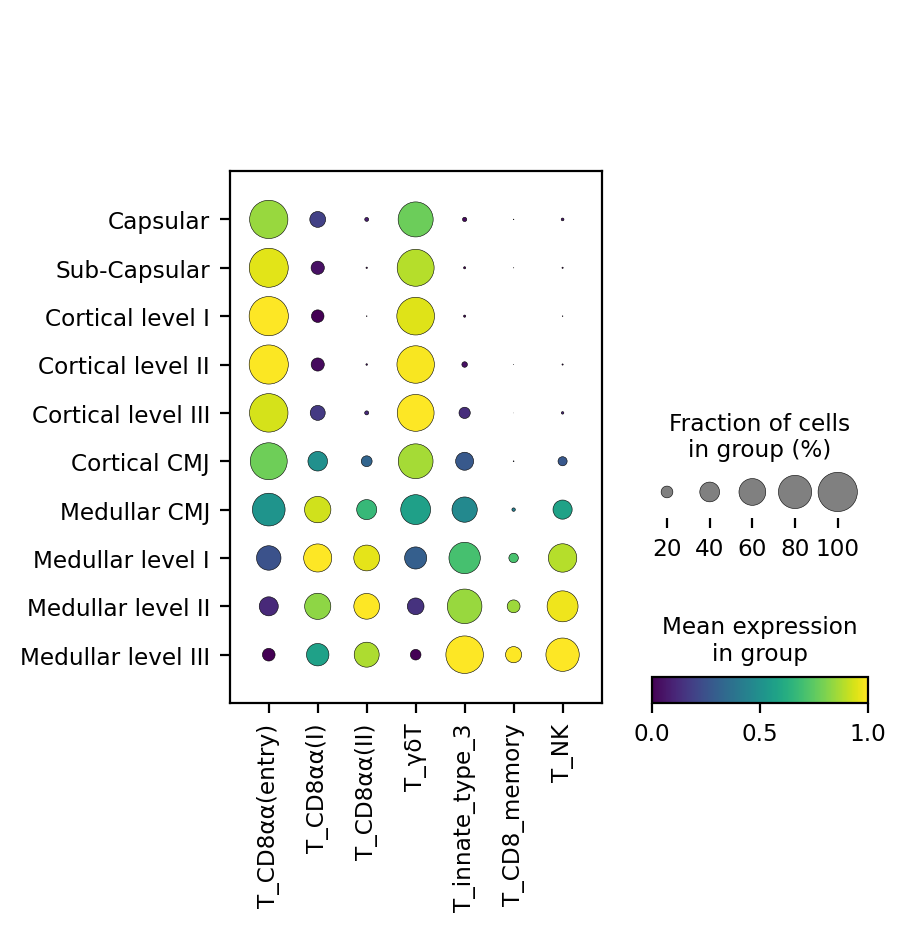

In [21]:
key = list(dict_anno.keys())[0]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 1
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf')

['T_DP(Q)-early', 'T_DN(Q)-CD99', 'T_DN(Q)-HSPH1', 'T_DP(Q)-CD99', 'T_DP(Q)-HSPH1', 'T_DP(Q)-late_vdj']
['T_DP(Q)-early', 'T_DP(Q)-CD99', 'T_DP(Q)-late_vdj']


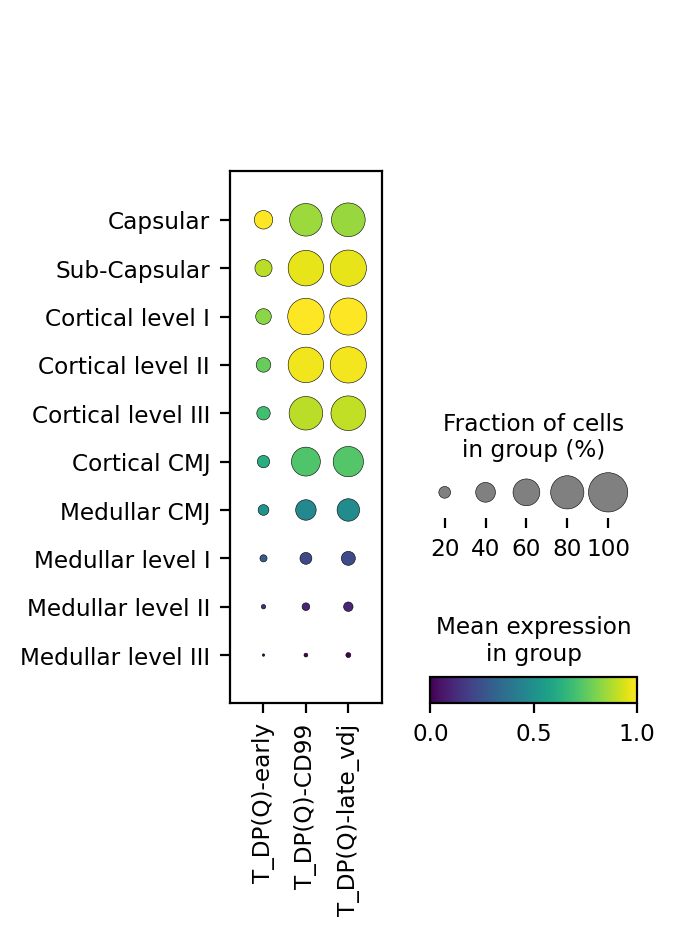

In [107]:
key = list(dict_anno.keys())[1]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 10
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf')

['T_reg(agonist)', 'T_reg(diff)-FOXP3Lo', 'T_reg(diff)-FOXP3hi', 'T_Treg_mature', 'T_Treg_CD8', 'T_Treg_recirc']
['T_Treg_mature', 'T_Treg_CD8', 'T_Treg_recirc']


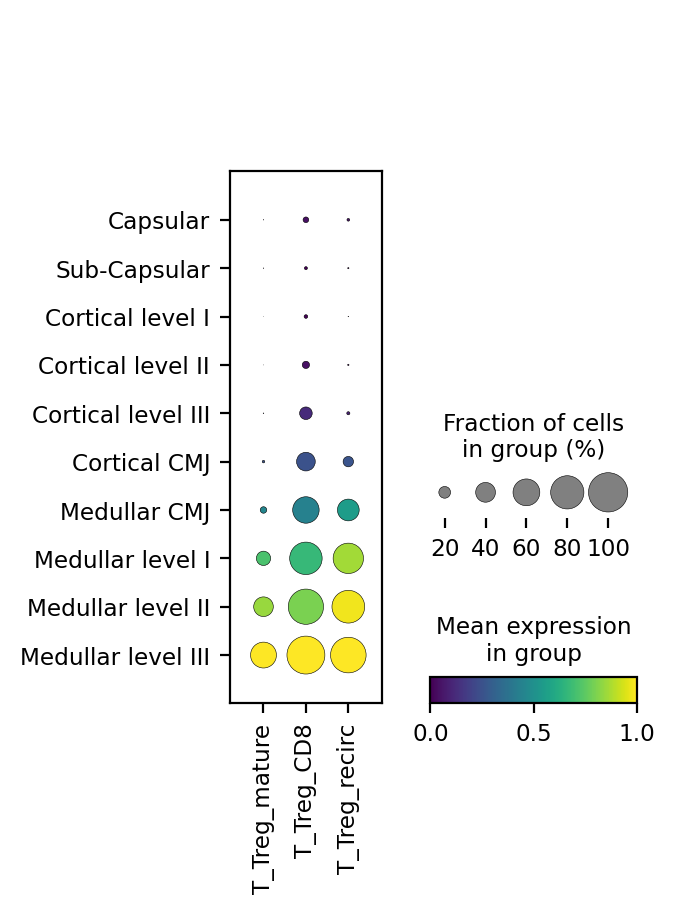

In [108]:
key = list(dict_anno.keys())[2]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 1
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf')

['B-naive', 'B-memory', 'B-Prolif', 'B-plasma']
['B-naive', 'B-memory', 'B-plasma']


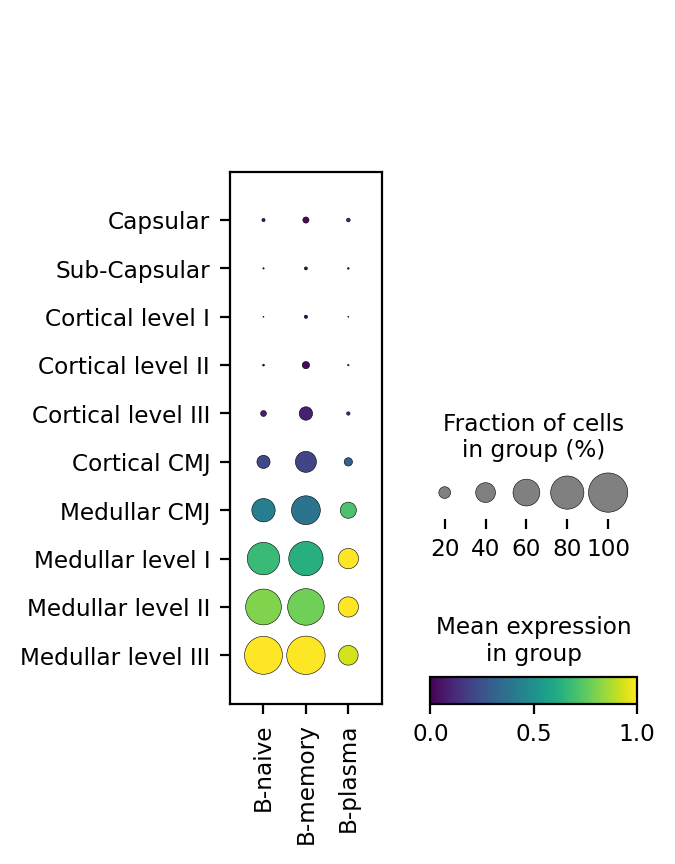

In [109]:
key = list(dict_anno.keys())[3]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 1
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf')

['Promonocyte', 'Monocyte_CCR2', 'Monocyte_IL1B', 'Myelocyte', 'Neutrophil', 'Mast', 'RBC']
['Monocyte_IL1B', 'Myelocyte', 'Neutrophil']


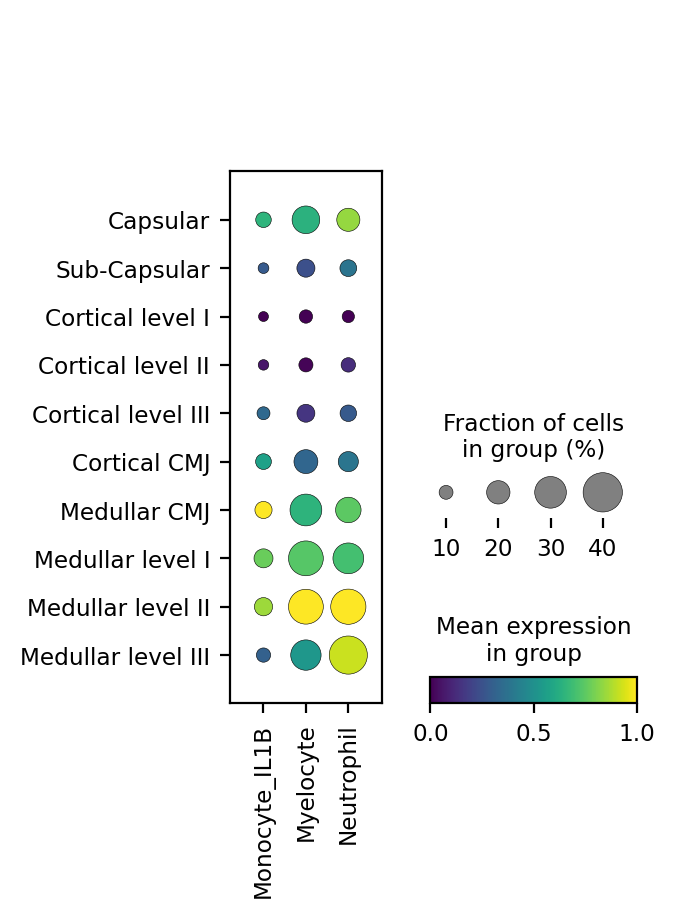

In [22]:
key = list(dict_anno.keys())[5]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 0.1
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf')

['DC1-Prolif', 'DC1', 'aDC1', 'DC2-Prolif', 'DC2', 'aDC2', 'pDC-Prolif', 'pDC', 'aDC3']
['DC1', 'aDC1', 'DC2', 'aDC2', 'pDC', 'aDC3']


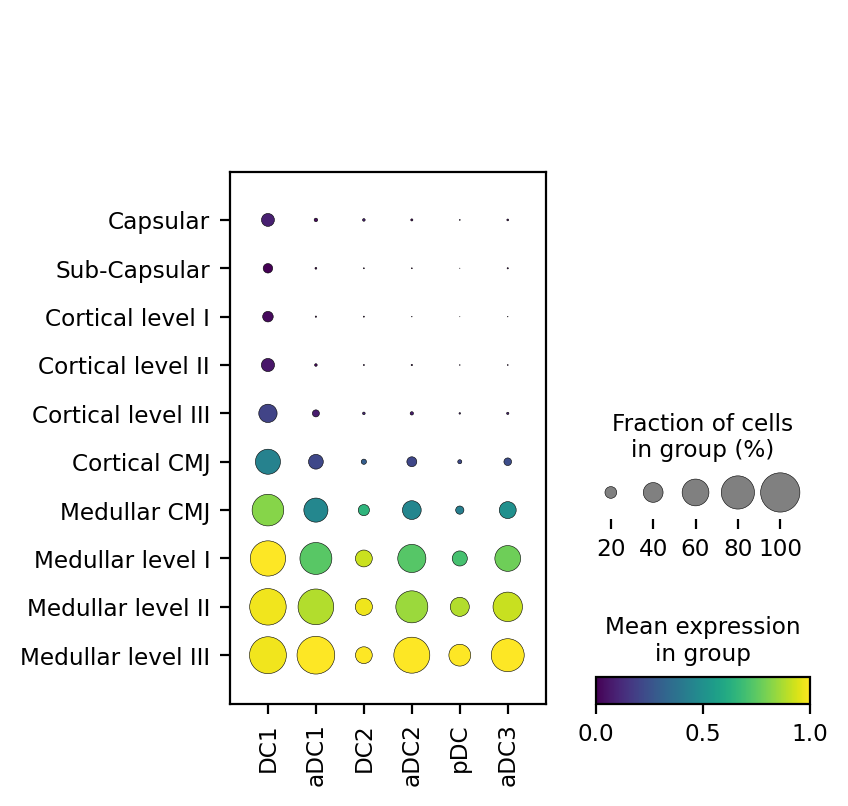

In [111]:
key = list(dict_anno.keys())[6]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 0.5
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf')

['Macrophage-APOC2', 'Macrophage-LYVE1', 'Macrophage-SPIC1']
['Macrophage-APOC2', 'Macrophage-SPIC1']


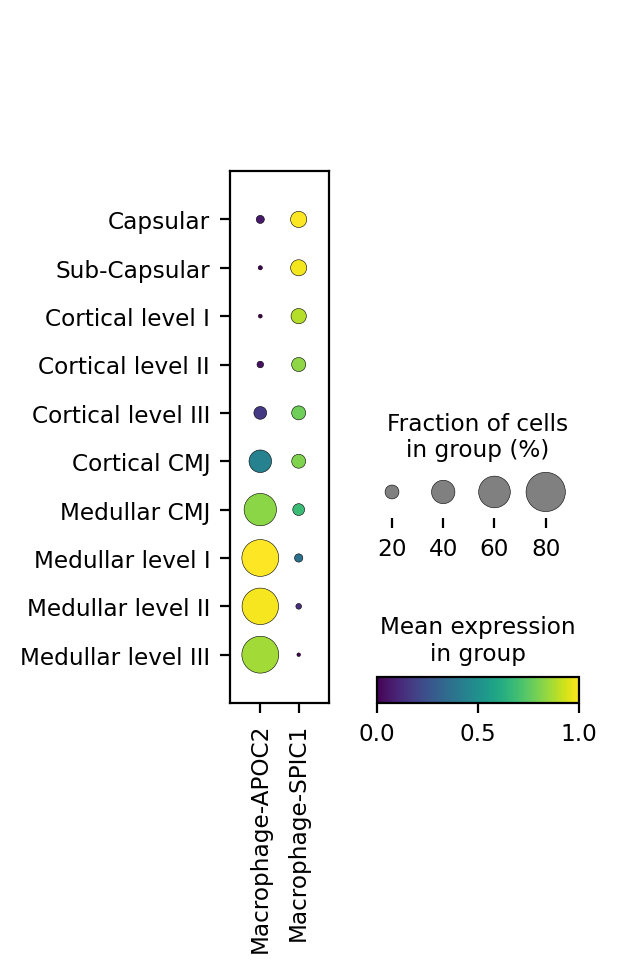

In [112]:
key = list(dict_anno.keys())[7]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 0.5
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf')

['EC-Art', 'EC-Art-ELN', 'EC-Cap', 'EC-Cap-Prolif', 'EC-Ven', 'EC-Ven-ELN', 'EC-Lymphatic']
['EC-Art', 'EC-Art-ELN', 'EC-Cap', 'EC-Ven', 'EC-Lymphatic']


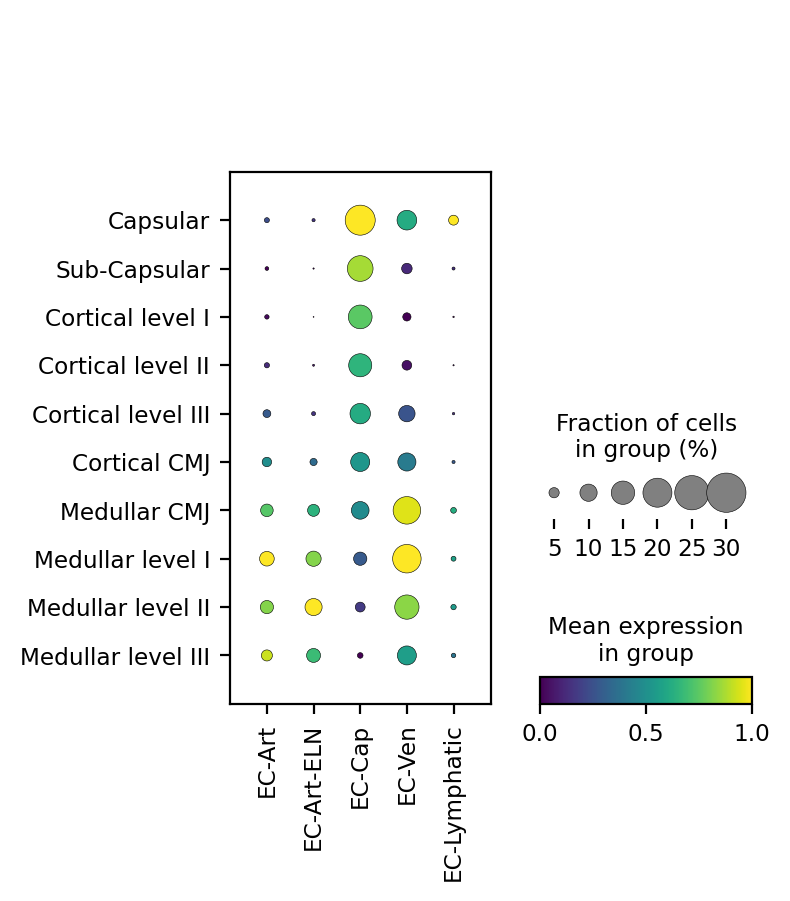

In [113]:
key = list(dict_anno.keys())[8]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 0.25
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf')

['Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'ProlifPericyte', 'SMC']
['Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'SMC']


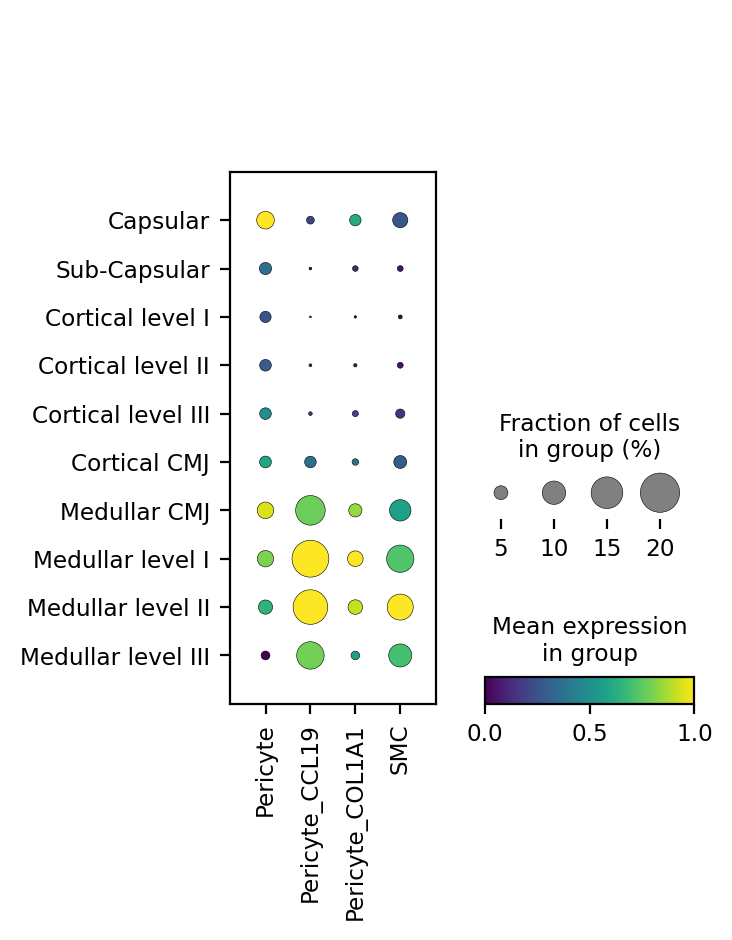

In [114]:
key = list(dict_anno.keys())[9]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 0.25
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf')

['PeriloFb', 'PeriloFb-Prolif', 'InterloFb', 'InterloFb-COL9A3', 'medFb', 'medFb-RGS5', 'medFB-MHCIIh', 'fetFB-CCL21', 'fetFB-NKX2-5', 'fetFB-RSPO2']
['PeriloFb', 'InterloFb', 'medFb', 'medFb-RGS5', 'medFB-MHCIIh']


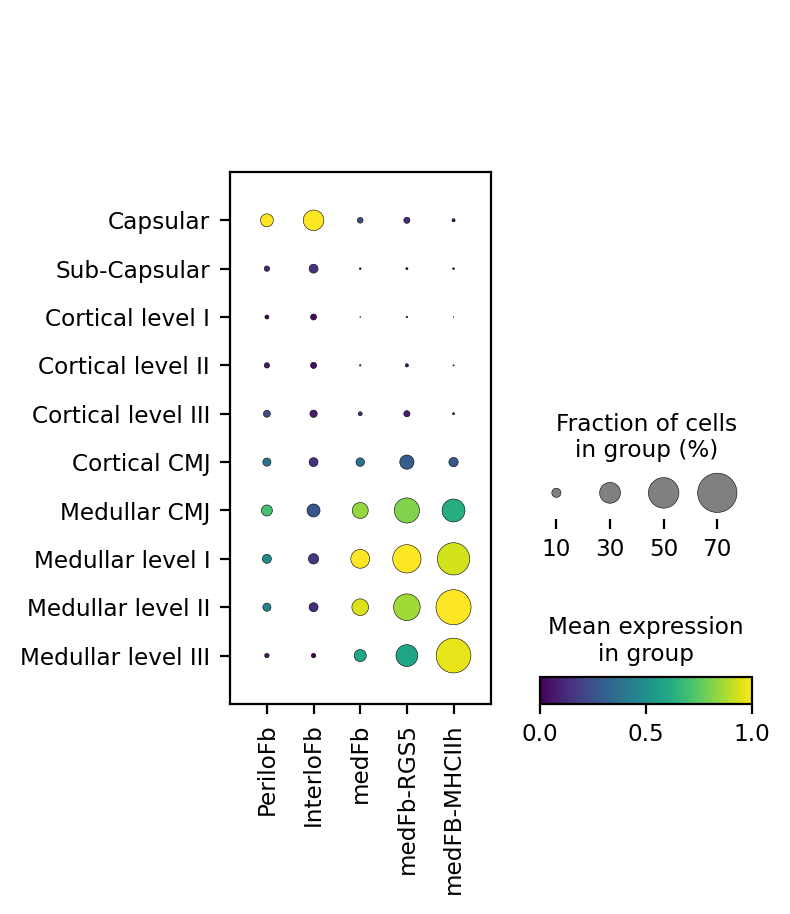

In [115]:
key = list(dict_anno.keys())[10]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 0.25
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf')